# FUNDAMENTOS DE APRENDIZAJE AUTOMÁTICO Y RECONOCIMIENTO DE PATRONES
## Práctico 7

In [1]:
# Se importan las bibliotecas que se utilizarán
import numpy as np

import matplotlib.pyplot as plt

from sklearn.datasets import load_iris
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import pairwise_distances
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from scipy.stats import multivariate_normal as mvn

from mpl_toolkits.mplot3d import Axes3D

from fuaa_utils_p7 import error_relativo
from fuaa_utils_p7 import validar_resultado

%matplotlib inline
# %matplotlib notebook
plt.rcParams['figure.figsize'] = (8, 8)

# Objetivos

- Aplicar **k-vecinos** más cercanos para **clasificar** entre las 10 categorías de **dígitos**. Optimizar el parámetro *k* utilizando la biblioteca *scikit-learn*.
- Estimar **densidades** de probabilidad mediante el método de **ventanas de Parzen** y aplicarlo a un problema de clasificación. 
- Implementar el algoritmo de **clustering k-means** y aplicarlo en datos sintéticos. Analizar su funcionamiento.   
- Realizar **agrupamiento de datos** mediante **mezcla de gaussianas**. Implementarlo utilizando el esquema **Expectation Maximization** para encontrar los parámetros. Comparar este agrupamiento con el de *k-means*.

# Lista de ejercicios

[Ejercicio 1](#Ejercicio1): *k-vecinos* más cercano       
[Ejercicio 2](#Ejercicio2): ventanas de Parzen   
[Ejercicio 3](#Ejercicio3): k-means   
[Ejercicio 4](#Ejercicio4): Mezcla de Gaussianas con EM   

<a id="Ejercicio1"></a>
# Ejercicio 1: vecino más cercano

En este ejercicio se utilizará *vecino más cercano* para clasificar la base de dígitos que viene con *scikit-learn*. La siguiente celda levanta los datos.

In [2]:
# se levantan los dígitos de la base MNIST 
mnist = load_digits()
print('La base de datos MNIST tiene %d dígitos' % len(mnist.data))

La base de datos MNIST tiene 1797 dígitos


In [9]:
print(mnist.keys())
print(mnist["target"])

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])
[0 1 2 ... 8 9 8]


In [14]:
train_test_split(mnist["data"], mnist["target"], train_size=0.7, test_size=0.1)

[array([[ 0.,  0.,  7., ..., 14.,  5.,  0.],
        [ 0.,  0.,  3., ...,  0.,  0.,  0.],
        [ 0.,  0.,  5., ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  2., ..., 11., 16.,  6.],
        [ 0.,  0.,  0., ..., 15.,  5.,  0.],
        [ 0.,  0.,  2., ..., 14.,  1.,  0.]]),
 array([[ 0.,  0.,  2., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ..., 15.,  0.,  0.],
        [ 0.,  0.,  3., ...,  7.,  0.,  0.],
        ...,
        [ 0.,  0.,  1., ...,  1.,  0.,  0.],
        [ 0.,  0.,  6., ..., 16., 16., 12.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]]),
 array([3, 4, 8, ..., 2, 1, 6]),
 array([4, 1, 9, 8, 4, 5, 5, 8, 0, 4, 7, 0, 5, 5, 5, 0, 5, 5, 2, 8, 5, 8,
        9, 9, 5, 1, 6, 7, 5, 6, 0, 5, 4, 4, 6, 8, 2, 8, 0, 4, 0, 2, 4, 3,
        6, 3, 7, 2, 9, 9, 9, 9, 5, 1, 8, 3, 5, 5, 9, 5, 2, 1, 3, 8, 9, 2,
        2, 3, 1, 2, 1, 9, 4, 1, 0, 1, 4, 4, 0, 0, 0, 7, 8, 6, 9, 3, 7, 7,
        0, 6, 7, 7, 5, 9, 2, 6, 3, 6, 9, 1, 0, 9, 2, 6, 3, 0, 8, 9, 4, 4,
        2, 7, 5, 5, 1, 1, 6

**Parte a)** Particionar aleatoriamente los datos utilizando el 70\% de las muestras para entrenamiento, el 10\% para validación y 20\% para test. Utilice `train_test_split()` de *scikit-learn*.

In [27]:
np.random.seed(35)
#####################################################
####### EMPIEZA ESPACIO PARA COMPLETAR CODIGO #######
#####################################################

N = mnist["data"].shape[0]

Ntrain = int(np.floor(0.7 * N))
Nval = int(np.floor(0.8 * N)) # Resta un 20% para test

indices = np.random.permutation(N)
indices_train = indices[:Ntrain]
indices_val = indices[Ntrain:Nval]
indices_test = indices[Nval:]

X_train, y_train = mnist["data"][indices_train], mnist["target"][indices_train]
X_val, y_val = mnist["data"][indices_val], mnist["target"][indices_val]
X_test, y_test = mnist["data"][indices_test], mnist["target"][indices_test]

######################################################
####### TERMINA ESPACIO PARA COMPLETAR CODIGO  #######
######################################################

# Se muestra el tamaño de los conjuntos generados
print("El conjunto de entrenamiento tiene {} dígitos".format(len(y_train)))
print("El conjunto de validación tiene {} dígitos".format(len(y_val)))
print("El conjunto de test tiene {} dígitos".format(len(y_test)))

validar_resultado('train_valid_test',X_train, X_val, X_test)

El conjunto de entrenamiento tiene 1257 dígitos
El conjunto de validación tiene 180 dígitos
El conjunto de test tiene 360 dígitos
+-------------------------------------------------------------------------+
|                         FuAA: validar resultado                         |
+-------------------------------------------------------------------------+
 Relación de tamaños de X_train y X_valid validada.
 Relación de tamaños de X_train, X_valid y X_test validada.
+-------------------------------------------------------------------------+


**Parte b)** Se utilizará la clase `KNeighborsClassifier` de *scikit-learn* para encontrar un clasificador mediante el método de vecino más cercano. Para encontrar el valor óptimo de *k* se usará el error con el conjunto de validación. 

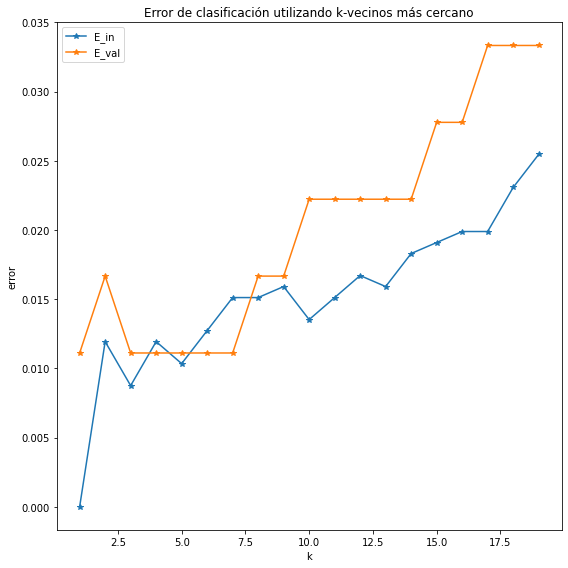

In [44]:
# se determina el rango de valores de k a probar
rango_k = range(1, 20)

# se inicializan la listas que guardarán E_in y E_val
E_in = []
E_val = []

for k in rango_k:

    #####################################################
    ####### EMPIEZA ESPACIO PARA COMPLETAR CODIGO #######
    #####################################################

    clasificadorKK = KNeighborsClassifier(n_neighbors=k)
    
    # se entrena el clasificador que usa k-vecinos, clf_knn
    clasificadorKK.fit(X_train, y_train)

    # se calculan y guardan E_in y E_val
    E_in.append(np.average(clasificadorKK.predict(X_train)!=y_train))

    E_val.append(np.average(clasificadorKK.predict(X_val)!=y_val))

    #####################################################
    ####### TERMINA ESPACIO PARA COMPLETAR CODIGO #######
    #####################################################

plt.figure()
plt.plot(rango_k, E_in, '*-', label='E_in')
plt.plot(rango_k, E_val, '*-', label='E_val')
plt.legend()
plt.xlabel('k')
plt.ylabel('error')
plt.title('Error de clasificación utilizando k-vecinos más cercano')
plt.tight_layout()

**Parte c)** ¿Cuál es el valor óptimo de *k* y el error con el conjunto de validación para dicho *k* ?

In [45]:
#####################################################
####### EMPIEZA ESPACIO PARA COMPLETAR CODIGO #######
#####################################################

# se encuentra el valor óptimo de k
k_opt = 3

# error con el conjunto de validación
e_val_opt = E_val[k_opt-1]

#####################################################
####### TERMINA ESPACIO PARA COMPLETAR CODIGO #######
#####################################################

print('El valor óptimo de k es %d, el error con el conjunto de validación es %f' % (k_opt, e_val_opt))

El valor óptimo de k es 3, el error con el conjunto de validación es 0.011111


**Parte d)** Entrenar el clasificador óptimo y general las predicciones con el conjunto de test.

In [46]:
#####################################################
####### EMPIEZA ESPACIO PARA COMPLETAR CODIGO #######
#####################################################

# se entrena el clasificador óptimo
knn_clf = KNeighborsClassifier(n_neighbors=k_opt)

knn_clf.fit(X_train, y_train)

# Predecir con test 
y_test_pred = knn_clf.predict(X_test)

#####################################################
####### TERMINA ESPACIO PARA COMPLETAR CODIGO #######
#####################################################

print('Matriz de confusión obtenida:\n')
print(confusion_matrix(y_test, y_test_pred))

Matriz de confusión obtenida:

[[41  0  0  0  0  0  0  0  0  0]
 [ 0 29  0  0  0  0  0  0  0  0]
 [ 0  0 41  0  0  0  0  0  0  0]
 [ 0  0  0 39  0  0  0  0  0  0]
 [ 0  0  0  0 31  0  0  0  0  0]
 [ 0  0  0  0  0 32  0  0  0  1]
 [ 0  0  0  0  0  0 40  0  1  0]
 [ 0  0  0  0  0  0  0 34  0  0]
 [ 0  0  0  0  0  0  0  0 35  0]
 [ 0  0  0  0  0  0  0  0  1 35]]


**Parte e)** Una forma alternativa de estimar los parámetros óptimos es mediante *validación cruzada* con *5 folds*. Utilice la clase `GridSearchCV` de *scikit-learn* para estimar los parámetros óptimos. 

In [47]:
#####################################################
####### EMPIEZA ESPACIO PARA COMPLETAR CODIGO #######
#####################################################

param_grid = {"n_neighbors": range(1,20)}
knn_cv = GridSearchCV(KNeighborsClassifier(), param_grid=param_grid, cv=5)   # GridSearchCV para k-nn

knn_cv.fit(X_train, y_train)

#####################################################
####### TERMINA ESPACIO PARA COMPLETAR CODIGO #######
#####################################################
print('k optimo mediante cv = %f' % knn_cv.best_params_['n_neighbors'])
print('accuracy = %f' % knn_cv.best_score_)

k optimo mediante cv = 5.000000
accuracy = 0.983308


**Parte f)** ¿Coinciden los valores óptimos encontrados? ¿Qué método le parece más adecuado para este problema en particular? 

**Respuesta:**  

Coinciden, solo que en el primero se eligió el menor para que resulte en un algoritmo más simple. 

**Parte g)** Dado el gran desempeño alcanzado por *k-nn* en la separación de dígitos, se merece una oportunidad en el problema de separación de sonidos urbanos del práctico anterior. Evalúelo y comente los resultados. 

<a id="Ejercicio4"></a>
# Ejercicio 2: ventanas de Parzen

En este ejercicio se utilizará la base de datos Iris para clasificación de flores disponible en *scikit learn*. Se considerará sólo el *largo* y el *ancho* del pétalo como características.

In [2]:
data = load_iris()
print(data['feature_names'])

['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']


**Parte a)** Construya el vector de características y las etiquetas que se utilizarán en este ejercicio.

In [36]:
# Se eligen dos características. 
features = [2, 3]

#####################################################
####### EMPIEZA ESPACIO PARA COMPLETAR CODIGO #######
#####################################################

caracteristicas = np.array(data["data"])

# Vector de características en X.
X = caracteristicas[:, features]

# Se almacenan las etiquetas en el vector labels.
labels = np.array(data["target"])
#####################################################
####### TERMINA ESPACIO PARA COMPLETAR CODIGO #######
#####################################################

A continuación se muestra la distribución de patrones para las tres clases presentes, cada
una de ellas con un color diferente.

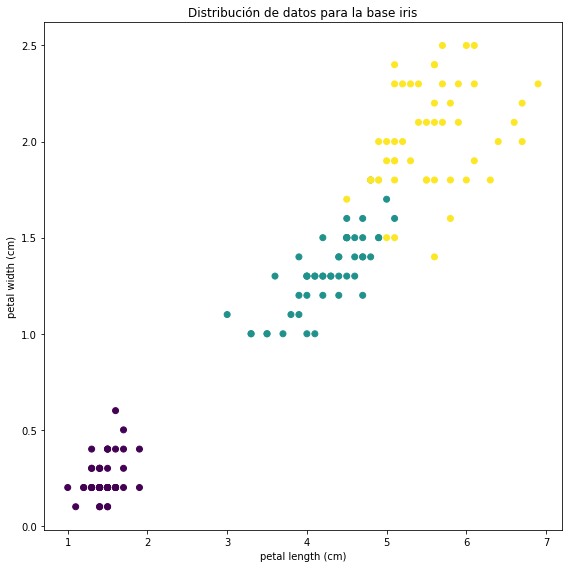

In [38]:
plt.figure()
plt.scatter(X[:, 0], X[:, 1], c=labels)
plt.xlabel(data['feature_names'][features[0]])
plt.ylabel(data['feature_names'][features[1]])
plt.title('Distribución de datos para la base iris')
plt.tight_layout()

Se desean estimar las densidades de cada clase utilizando el método de ventanas de Parzen con un *kernel* gaussiano de la forma: 

$$
K(\mathbf{x}, \mathbf{z_i})=\frac{1}{(2\pi)^{d/2}\vert \Sigma \vert^{1/2}} 
                               \exp ^{\left(-\frac{1}{2}\left( \mathbf{x} - \mathbf{z_i} \right)^T 
                                        \Sigma^{-1} \left( \mathbf{x} - \mathbf{z_i} \right) \right)}
$$

**Parte b)** Implementar el método `evaluar_kernel_gaussiano()`. Dicho método se utilizará para determinar la similitud entre la muestra a evaluar $\mathbf{x}$ y una muestra de entrenamiento $\mathbf{z_i}$ utilizando un *kernel gaussiano*. 

In [305]:
def evaluar_kernel_gaussiano(x, mu, Sigma):
    '''
    Entrada:
        x: vector a evaluar de dimensión (d,1)
        mu: media del núcleo gaussiano de dimensión (d,1)
        Sigma: covarianza del núcleo gaussiano de dimensión (d,d)
    Salida:
        p: resultado de evaluar el kernel gaussiano
    '''
    #####################################################
    ####### EMPIEZA ESPACIO PARA COMPLETAR CODIGO #######
    #####################################################
    
    d = x.shape[0]
    
    aux = 1/((2*np.pi)**(d/2) * np.sqrt(np.linalg.det(Sigma)))
    
    p = aux * np.exp(-0.5*(x-mu).T @ np.linalg.inv(Sigma) @ (x-mu))
    
    #####################################################
    ####### EMPIEZA ESPACIO PARA COMPLETAR CODIGO #######
    #####################################################

    p = np.squeeze(p)  # para asegurar que la salida es un escalar
    return p

In [306]:
# Se testea evaluar_kernel_gaussiano()
validar_resultado('evaluar_kernel_gaussiano', funcion=evaluar_kernel_gaussiano)

+-------------------------------------------------------------------------+
|                         FuAA: validar resultado                         |
+-------------------------------------------------------------------------+
 Resultado de kernel gaussiano validado.
+-------------------------------------------------------------------------+


**Parte c)** Implementar el método `estimar_densidad()` que evalúa, en un conjunto de puntos X, la densidad de probabilidad de pertenecer a una clase. La densidad se estima mediante el método de ventanas de Parzen utilizando los patrones de entrenamiento de dicha clase.

In [58]:
def estimar_densidad(X, Z, Sigma):
    '''
    Utiliza los patrones de entrenamiento Z pertenecientes a una misma clase, para 
    evaluar la densidad de probabilidad de dicha clase en los puntos pasados en X. 
    La densidad se estima mediante el método de ventanas de Parzen con núcleo gaussiano.   
    Entrada:
        X: matriz de tamaño Nxd que contiene los puntos en donde se quiere 
           evaluar la densidad
        Z: matriz de tamaño Mxd que contiene los puntos de entrenamiento
        Sigma: matriz de covarianza del kernel gaussiano
    Salida:
        densidades: vector de tamaño N que almacena la densidad en los puntos evaluados
    '''

    N, d = X.shape
    M, d = Z.shape

    #####################################################
    ####### EMPIEZA ESPACIO PARA COMPLETAR CODIGO #######
    #####################################################

    densidades = np.empty((N,M))
    for i in range(N):
        for j in range(M):
            densidades[i,j] = evaluar_kernel_gaussiano(X[i], Z[j], Sigma)
            
    densidades = np.average(densidades, axis=1)
    #####################################################
    ####### TERMINA ESPACIO PARA COMPLETAR CODIGO #######
    #####################################################

    return densidades

In [59]:
# Se testea estimar_densidad()
validar_resultado('estimar_densidad', funcion=estimar_densidad)

+-------------------------------------------------------------------------+
|                         FuAA: validar resultado                         |
+-------------------------------------------------------------------------+
 Resultado de densidades estimadas validado.
+-------------------------------------------------------------------------+


**Parte d)** Se estimará la densidad de cada una de las clases de la base Iris en una grilla de 50x50 puntos.
Se considerará para la estimación de las densidades una matriz $\Sigma$ de la forma $\Sigma=r^2 \Sigma_c$ siendo $\Sigma_c$ la matriz de covarianza de los datos pretenecientes a la clase y $r$ el parámetro que controla el ancho del *núcleo gaussiano*. 

/tmp/ipykernel_8767/1336697984.py:41: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


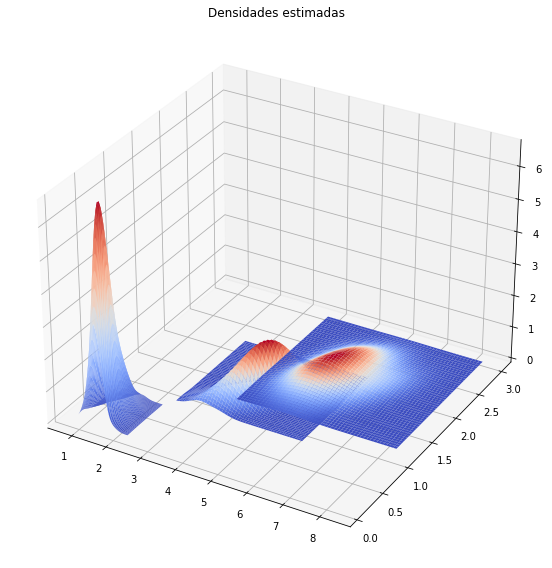

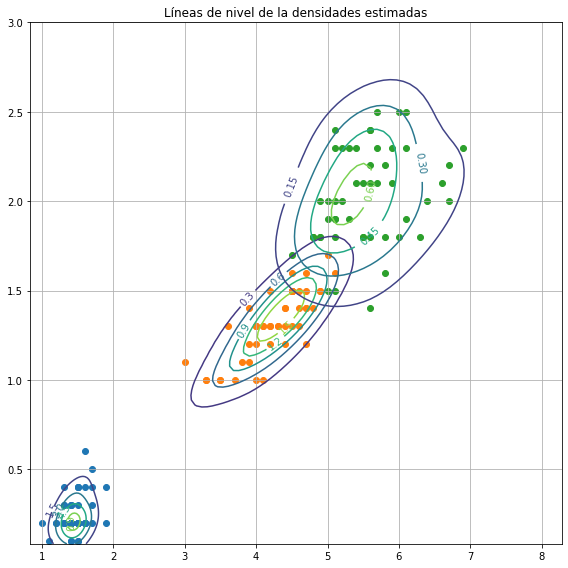

In [121]:
r = 0.8  # ancho del núcleo gaussiano

for c in range(3):  # para cada una de las clases

    # se crea la grilla de 50x50 puntos que cubre el dominio de los puntos de la clase
    x = np.linspace(X[labels == c, 0].min() / 1.2,
                    X[labels == c, 0].max() * 1.2)
    y = np.linspace(X[labels == c, 1].min() / 1.2,
                    X[labels == c, 1].max() * 1.2)
    xx, yy = np.meshgrid(x, y)

    #####################################################
    ####### EMPIEZA ESPACIO PARA COMPLETAR CODIGO #######
    #####################################################

    # Se calculan las densidades en los puntos de la grilla. El arreglo 
    #    'densidades' tiene que tener las mismas dimensiones que xx e yy.
    # Se sugiere:
    #    1. agrupar los puntos de la grilla convenientemente para calcular las
    #       densidades. Para calcular las densidades puede ser útil np.cov() y
    #       verificar que las dimensiones de Sigma son las correctas.
    #    2. redimensionar las densidades calculadas de forma que coincidan con
    #       las de xx e yy.

    puntos_plano = np.dstack((xx, yy)).reshape((2500, 2)) # array con los puntos del plano
    densidades = np.empty((50,50))
    
    puntos_clase = X[(labels==c)]
    Sigma_c = np.cov(puntos_clase, rowvar=False)
    Sigma = r**2 * Sigma_c
    
    densidades = estimar_densidad(puntos_plano, puntos_clase, Sigma)
    densidades = densidades.reshape((50,50))
 
    #####################################################
    ####### TERMINA ESPACIO PARA COMPLETAR CODIGO #######
    #####################################################

    # Mostrar las densidad estimadas.
    fig = plt.figure(num='surface')
    ax = fig.gca(projection='3d')
    surf = ax.plot_surface(xx,
                           yy,
                           densidades,
                           rstride=1,
                           cstride=1,
                           cmap=plt.cm.coolwarm)

    # Mostrar los puntos junto con las líneas de nivel de las densidades
    # estimadas.
    plt.figure(num='contour')
    plt.scatter(X[labels == c, 0], X[labels == c, 1])
    cs = plt.contour(xx, yy, densidades, levels=5)
    plt.clabel(cs, inline=1, fontsize=10)


# Poner títulos y etiquetas.
fig = plt.figure(num='surface')
plt.title('Densidades estimadas')
plt.tight_layout()

plt.figure(num='contour')
plt.grid()
plt.title('Líneas de nivel de la densidades estimadas')
plt.tight_layout()

In [131]:
print(yy.shape)

(50, 50)


**Parte e)** Comente sobre la influencia del ancho de banda *r*  en las densidades estimadas y establezca un rango de valores razonable. Proponga un mecanismo para determinarlo automáticamente, esto es especialmente útil en aquellos casos en que no es posible visualizar las densidades resultantes.

**Respuesta:**    

Mientras mayor el valor de r, más grande es la desviación de las gaussianas y menores son la probabilidades totales.

Mientras más chico el valor de r, más se sobre ajusta el modelo a los datos.

Para determinarlo aut


<a id="Ejercicio3"></a> 
# Ejercicio 3: k-means

En este ejercicio se verá k-means como técnica de agrupamiento de datos.

**Parte a)** Completar la implementación del algoritmo k-means.

In [2]:
def k_means(X, k, semilla=43):
    '''
    Entrada:
        X - arreglo de tamaño (N,d) que contiene los vectores de entrada
        k - numero de clusters a encontrar
        semilla - semilla que se usa para inicializar los centros.
                  Elegir aleatoriamente k vectores de X
    Salida:
        centros: arreglo de tamaño (N,d) que contiene los centros de los 
                 clusters encontrados
        etiquetas: vector de largo N que contiene los clusters 
                   a los que se asignaron las muestras  
    '''

    np.random.seed()
    convergio = False
    n_iter = 0

    #####################################################
    ####### EMPIEZA ESPACIO PARA COMPLETAR CODIGO #######
    #####################################################

    # Se inicializan los centros de los clusters a muestras elegidas
    # aleatoriamente.
    
    centros = np.random.rand(k, X.shape[1])
    # reservo el lugar para los centro nuevos 
    centros_nuevos = np.empty(centros.shape)

    convergio = False
    n_iter = 0

    while not convergio:

        n_iter += 1
        # 1. Se asignan las etiquetas al cluster cuyo centro es el más cercano.
        # Se sugiere usar pairwise_distances del paquete metrics de sklearn.

        distancias = pairwise_distances(X, Y=centros) 
        etiquetas = np.argmin(distancias, axis=1)
        
        # 2. Se calculan los nuevos centros
        for etiqueta in range(0, k):
            elementos_i = X[etiqueta==etiquetas, :]
            if len(elementos_i) > 0:
                centros_nuevos[etiqueta, :] = np.mean(elementos_i, axis=0)
            else:
                centros_nuevos[etiqueta] = centros[etiqueta]
        # 3. Se evalúa la condición de convergencia (que los centros no cambien)
        convergio = np.all(centros==centros_nuevos)


        # 4. Se actualiza la variable centros y se aumenta el número de iteración
        centros = centros_nuevos.copy()

    #####################################################
    ####### TERMINA ESPACIO PARA COMPLETAR CODIGO #######
    #####################################################

    print('El algoritmo finalizó en la iter %d' % n_iter)
    return centros, etiquetas

**Parte b)** Aplicarlo al conjunto de datos del archivo `data/data_4clusters.npz`. La variable `X` contiene los patrones a agrupar. En este caso el número de clusters es 4.

Dimensiones de los datos de entrada: (500, 2)
El algoritmo finalizó en la iter 9


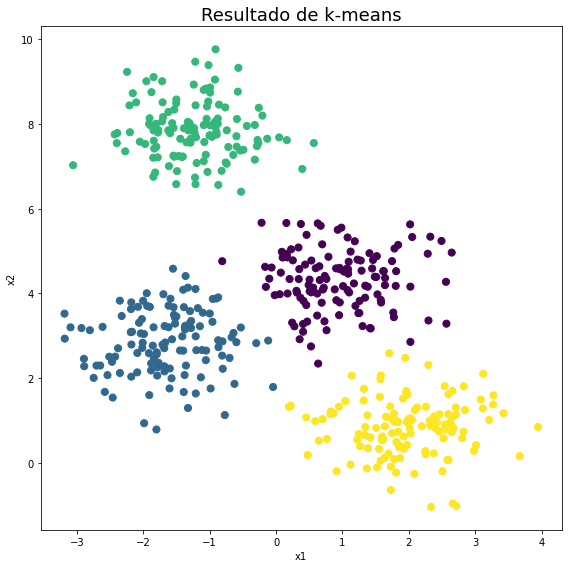

In [3]:
f = np.load('data/data_4clusters.npz')
X = f['X']
y = f['y']
print('Dimensiones de los datos de entrada:', X.shape)

#####################################################
####### EMPIEZA ESPACIO PARA COMPLETAR CODIGO #######
#####################################################

centros, asignaciones = k_means(X, 4, semilla=0)

#####################################################
####### TERMINA ESPACIO PARA COMPLETAR CODIGO #######
#####################################################

dot_size = 50
cmap = 'viridis'
fig, ax = plt.subplots()
ax.scatter(X[:, 0], X[:, 1], c=asignaciones, s=dot_size, cmap=cmap)
plt.title('Resultado de k-means', fontsize=18)
plt.xlabel('x1')
plt.ylabel('x2')
plt.tight_layout()

**Parte c)** Verificar el correcto funcionamiento del algoritmo comparando los resultados obtenidos con los de la variable `y`. Para ello usar algunas de las [métricas](https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation) disponibles en *scikit-learn*. 

In [216]:
adj_rand_score = metrics.rand_score(y, asignaciones)

adj_mi_score = metrics.mutual_info_score(y, asignaciones) 


print('El desempeño con adjusted random score es %f' % adj_rand_score)
print('El desempeño con adjusted mutual information score es %f' % adj_mi_score)

El desempeño con adjusted random score es 0.996016
El desempeño con adjusted mutual information score es 1.362981


**Parte d)** Al variar el valor de la semilla que controla la inicialización ¿Siempre obtuvo resultados satisfactorios? En caso negativo, proponga un esquema para robustecer el método.

**Respuesta:**    

Cambia los colores. 

Tirando seeds al azar hay 1 que no anduvo.

**Parte e)** Utilice el algoritmo k-means para separar el conjunto de datos `data_4clusters_stretched` y comente los resultados.

El algoritmo finalizó en la iter 14


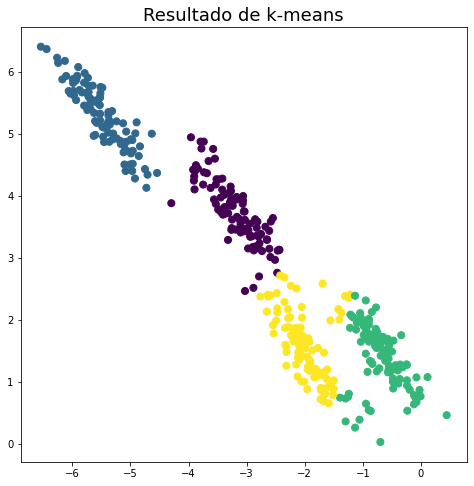

In [217]:
f = np.load('data/data_4clusters_stretched.npz')
f.files
X_st = f['X_st']
y_st = f['y_st']

#####################################################
####### EMPIEZA ESPACIO PARA COMPLETAR CODIGO #######
#####################################################

centros_stretched, asignaciones_stretched = k_means(X_st, k=4)


#####################################################
####### TERMINA ESPACIO PARA COMPLETAR CODIGO #######
#####################################################

fig, ax = plt.subplots()
ax.scatter(X_st[:, 0],
           X_st[:, 1],
           c=asignaciones_stretched,
           s=dot_size,
           cmap=cmap)
plt.title('Resultado de k-means', fontsize=18)
plt.draw()

**Respuesta:**   
...

<a id="Ejercicio4"></a>
# Ejercicio 4: EM

El objetivo de este ejercicio es implementar el esquema Expectation Maximization (EM) para encontrar los parámetros que maximizan la verosimilitud del modelo Mezcla de Gaussianas para un conjunto de datos $X$. Si se utilizan $\textit{K}$ componentes en la mezcla, el modelo está dado por:
$$p(\mathbf{x_n|\Theta})=\sum_{j=1}^K w_j \mathcal{N}\left( \mathbf{x_n} \vert \mathbf{\mu_j},\mathbf{\Sigma_j} \right).$$

Se implementará una función que utiliza el esquema EM para encontrar los parámetros óptimos en el caso de Mezcla de Gaussianas. Dentro de la función el esquema sigue los siguientes pasos:

1. Inicialización
2. Loop donde se calculan:
    - *Expectation Step* 
    - *Maximization Step*  
    - log verosimilitud de los datos
    - se evalúa condición de continuidad en el loop


**Parte a)** Implementar la función `inicializar_mezcla()` que es la encargada de inicializar las medias $\mathbf{\mu_j}$, las covarianzas $\mathbf{\Sigma_j}$ y los coeficientes $\mathbf{w}$ de la mezcla . Para facilitar la comparación con el algoritmo *k-means* del ejercicio anterior se sugiere inicializar los $\mathbf{\mu_j}$ a $\textit{k}$ vectores de $X$ elegidos aleatoriamente. 

In [499]:
def inicializar_mezcla(X, k, semilla):
    '''
    Entrada:
        X: matriz de tamaño (N,d) que contiene N muestras, una por fila
        k: número de clusters a encontrar
    Salida:
        w: arreglo de largo k que contiene los pesos de la mezcla. 
           Se deben inicializar a valores aleatorios cuya suma da 1 
        mus: arreglo de tamaño (k,d) que contiene los pesos
        sigmas: arreglo de tamaño (k,d,d) que contiene las matrices de covarianza de los clusters
    '''
    N, d = X.shape

    # la semilla controla la inicialización de los parámetros
    np.random.seed(semilla)

    #####################################################
    ####### EMPIEZA ESPACIO PARA COMPLETAR CODIGO #######
    #####################################################

    # se inicializan los mus eligiendo k muestras de X al azar

    mus = X[np.random.randint(low=0, high=N, size=(k, ))]
    
    # los sigmas se inicializan a la identidad
    sigmas = np.tile(np.eye(d), (k, 1)).reshape(k,d,d)

    # se inicializan el vector de pesos
    w = np.random.uniform(size=k)
    w = w/np.sum(w)
    ######################################################
    ####### TERMINAA ESPACIO PARA COMPLETAR CODIGO #######
    ######################################################

    return w, mus, sigmas

In [497]:
# Se testea inicializar_mezcla()
validar_resultado('inicializar_mezcla', funcion=inicializar_mezcla)

+-------------------------------------------------------------------------+
|                         FuAA: validar resultado                         |
+-------------------------------------------------------------------------+
 Suma de w_i: validado.
 Todos los w_i son no negativos: validado.
 Tamaño de matriz de mus: validado.
 Matriz Sigma es identidad: validado.
 Matriz Sigma es identidad: validado.
+-------------------------------------------------------------------------+


**Parte b)** Implementar `expectation_step`. Se calcula la probabilidad de que la *n-ésima* muestra haya sido generada por la componente *j-ésima* de la mezcla. Para ello se utilizan los parámetros actuales   

$$
\gamma_{nj} = \frac{w_j \mathcal{N}\left( \mathbf{x_n} \vert \mathbf{\mu_j},\mathbf{\Sigma_j} \right)}{\sum_{l=1}^{L} w_l \mathcal{N}\left( \mathbf{x_n} \vert \mathbf{\mu_l},\mathbf{\Sigma_l} \right)} 
$$

In [474]:
def expectation_step(X, w, mus, sigmas):
    '''
    Entrada:
        X: matriz de tamaño (N,d) con las muestras a evaluar.
        w: vector de largo k que contiene los pesos de la mezcla. 
        mus: arreglo de tamaño (k,d) que contiene las k medias.
        sigmas: arreglo de tamaño (k,d,d) que contiene las matrices de covarianza de los clusters.
    Salida:
        gammas: matriz de tamaño (N,k) con las probabilidades de pertenencia a cada cluster.
    '''

    #####################################################
    ####### EMPIEZA ESPACIO PARA COMPLETAR CODIGO #######
    #####################################################
    N, d = X.shape
    k = w.shape[0]

    gammas = np.empty((N, k))
    
    for n in range(N):
        for j in range(k):
            gammas[n,j] = w[j] * evaluar_kernel_gaussiano(X[n], mus[j], sigmas[j])
        sum_gamma = np.sum(gammas[n])
        gammas[n] = gammas[n] / sum_gamma
        
    #####################################################
    ####### TERMINA ESPACIO PARA COMPLETAR CODIGO #######
    #####################################################

    return gammas

In [475]:
# Se testea expectation_step()
validar_resultado('expectation_step', funcion=expectation_step)

+-------------------------------------------------------------------------+
|                         FuAA: validar resultado                         |
+-------------------------------------------------------------------------+
 Probabilidades de pertenencia a cada cluster validadas.
+-------------------------------------------------------------------------+


**Parte c)** Implementar `maximization_step()`. Se encuentran los parámetros óptimos utilizando la distribución de $\gamma_{nj}$ actual

\begin{align*}
&N_j                       = \sum_{n=1}^{N}\gamma_{nj} \\
&\mathbf{\mu_j^{new}}      = \frac{1}{N_j}\sum_{n=1}^{N}\gamma_{nj}\mathbf{x_n}  \\
&\mathbf{\Sigma_j^{new}}   = \frac{1}{N_j}\sum_{n=1}^{N}\gamma_{nj}\left(\mathbf{x_n}-\mathbf{\mu_j}\right)\left(\mathbf{x_n}-\mathbf{\mu_j}\right)^T  \\
&w_j^{new}               = \frac{N_j}{N} \\
\end{align*}

In [476]:
def maximization_step(X, gammas):
    '''
    Entrada:
        X: matriz de tamaño (N,d) con las muestras a evaluar.
        gammas: arreglo de tamaño (N,k) con las probabilidades de pertenencia a
                cada cluster.
        
    Salida:
        w: vector de pesos de la mezcla.
        mus: arreglo de tamaño (k,d) que contiene las medias en el paso actual.
        sigmas: arreglo de tamaño (k,d,d) que contiene las matrices de 
                covarianza de los clusters en el paso actual.    
    '''

    #####################################################
    ####### EMPIEZA ESPACIO PARA COMPLETAR CODIGO #######
    #####################################################

    N, d = X.shape
    k = gammas.shape[1]
    
    Nj = np.sum(gammas, axis=0) 
    
    w = Nj / N

    mus = np.empty((k,d))
    
    sigmas = np.zeros((k,d,d))
    for j in range(k):
        mus[j] = (gammas[:, j] @ X) / Nj[j]
        for n in range(N):
            sigmas[j] += gammas[n,j] * ((X[n]-mus[j]).reshape((d,1)) @ (X[n]-mus[j]).reshape(1,d))
        sigmas[j] /= Nj[j]

    #####################################################
    ####### TERMINA ESPACIO PARA COMPLETAR CODIGO #######
    #####################################################

    return w, mus, sigmas

In [477]:
# Se testea maximization_step()
validar_resultado('maximization_step', funcion=maximization_step)

+-------------------------------------------------------------------------+
|                         FuAA: validar resultado                         |
+-------------------------------------------------------------------------+
 Vector de pesos de la mezcla: validado.
 Medias en los cluster: validadas.
 Matrices de covarianza: validadas.
+-------------------------------------------------------------------------+


**Parte e)** Implemente el método `log_verosimilitud()` que evalúa la log-verosimilitud de los datos con el modelo. 

In [478]:
def log_verosimilitud(X, w, mus, sigmas):
    
    '''
    Entrada:
        X: matriz de tamaño (N,d) que contiene las muestras.
        w: arreglo de tamaño k que contiene los pesos actuales.
        mus: arreglo de tamaño (k,d) que contiene las medias, una por fila.
        sigmas: arreglo de tamaño (k,d,d) que contiene las matrices # de covarianza.
     Salida:
        log_ver: log verosimilitud de las muestras con el modelo.
    '''

    #####################################################
    ####### EMPIEZA ESPACIO PARA COMPLETAR CODIGO #######
    #####################################################

    N, d = X.shape
    k = mus.shape[0]
    
    log_ver = 0
    for n in range(N):
        prob_n = 0
        for j in range(k):
            prob_n += w[j] * evaluar_kernel_gaussiano(X[n], mus[j], sigmas[j])
        log_ver += np.log(prob_n)

    # log_ver = sum(np.log(sum(w[j]*evaluar_kernel_gaussiano(X[n], mus[j], sigmas[j]) for j in range(k)))for n in range(N))  
    #####################################################
    ####### TERMINA ESPACIO PARA COMPLETAR CODIGO #######
    #####################################################

    return log_ver

In [479]:
# Se testea log_verosimilitud()
validar_resultado('log_verosimilitud', funcion=log_verosimilitud)

+-------------------------------------------------------------------------+
|                         FuAA: validar resultado                         |
+-------------------------------------------------------------------------+
 Verosimilitud validada.
+-------------------------------------------------------------------------+


**Parte f)** Complete la implementación de `gmm_EM`. Para ello utilice las implementaciones de las partes anteriores.

In [494]:
def gmm_EM(X, k, tol=0.01, max_iter=100, semilla = 2):
    '''
    Entrada:
        X: matriz de tamaño (N,d) que contiene N muestras, una por fila
        k: número de clusters a encontrar
        tol: si la log verosimilitud en el paso actual no mejora al menos tol
             respecto a la del paso anterior se termina la optimización 
        max_iter: máximo número de iteraciones en la optimización
        semilla: semilla a utilizar en la inicialización de las gaussianas
    Salida:
        log_ver: lista que almacena las log-verosimilitudes calculadas durante la optimización
        gammas: matriz de tamaño Nxk con las probabilidades de pertenencia a cada cluster
        w: vector de tamaño k que contiene los pesos estimados
        mus: matriz de tamaño (k,d) que contiene las medias, una por fila
        sigmas: arreglo de tamaño (k,d,d) que contiene las matrices de covarianza
    '''
    N, d = X.shape
    
    w, mus, sigmas = inicializar_mezcla(X, k, semilla)
    print(mus)

    log_ver_previa = -np.infty ; 
    log_ver=[] # lista que almacena las log-verosimilitudes durante la optimización
    
    termino = False
    n_iter = 0
    print('+------+-------------------+')
    print('| iter | log verosimilitud |')
    print('+------+-------------------+')
    while not termino:
        
        #####################################################
        ####### EMPIEZA ESPACIO PARA COMPLETAR CODIGO #######
        #####################################################
        
        # E-step   
        gammas = expectation_step(X, w, mus, sigmas)
        
        # M-step        
        w, mus, sigmas = maximization_step(X, gammas)
        # se actualiza la log verosimilitud
        log_ver_actual = log_verosimilitud(X, w, mus, sigmas)
        
        # se evalúa condición de terminación (dos condiciones)
        termino = abs(log_ver_actual-log_ver_previa) < tol or n_iter > max_iter
        
        #####################################################
        ####### TERMINA ESPACIO PARA COMPLETAR CODIGO #######
        #####################################################
        
        log_ver.append(log_ver_actual)
        log_ver_previa = log_ver_actual

        n_iter += 1
    
        print('| %3d  |      %8.2f     |' % (n_iter, log_ver_actual))

    print('+------+-------------------+')        
    return log_ver, gammas, w, mus, sigmas

## Evaluación utilizando data_4clusters

La siguiente celda evalúa la implementación realizada. Verifique que la log verosimilitud es monótona creciente.

In [ ]:
f = np.load('data/data_4clusters_stretched.npz')
f.files
X_st = f['X_st']
y_st = f['y_st']
log_vero, gammas, w, mus, sigmas = gmm_EM(X_st,
                                          k=4,
                                          max_iter=100,
                                          tol=0.001,
                                          semilla=22)

plt.figure()
plt.plot(log_vero)
plt.title('Log verosimilitud', fontsize=18)
plt.xlabel('iteraciones')
plt.draw()

[[-2.04740489  1.51674839]
 [-4.96157256  4.51803958]
 [-5.11227012  4.81397174]
 [-3.26370467  3.45251264]]
+------+-------------------+
| iter | log verosimilitud |
+------+-------------------+
|   1  |       -975.01     |
|   2  |       -931.71     |
|   3  |       -902.86     |
|   4  |       -891.03     |
|   5  |       -887.59     |
|   6  |       -885.42     |
|   7  |       -883.71     |
|   8  |       -882.48     |
|   9  |       -881.75     |
|  10  |       -881.40     |
|  11  |       -881.24     |
|  12  |       -881.14     |
|  13  |       -881.07     |
|  14  |       -880.99     |
|  15  |       -880.92     |
|  16  |       -880.83     |
|  17  |       -880.73     |
|  18  |       -880.62     |
|  19  |       -880.50     |
|  20  |       -880.37     |
|  21  |       -880.24     |
|  22  |       -880.11     |
|  23  |       -879.98     |
|  24  |       -879.85     |
|  25  |       -879.72     |
|  26  |       -879.59     |
|  27  |       -879.46     |
|  28  |       -879.3

**Parte g)** Realice la asignación de clusters y compare los resultados con los obtenidos con el algoritmo *k-means*.

In [482]:
#####################################################
####### EMPIEZA ESPACIO PARA COMPLETAR CODIGO #######
#####################################################

# vector de tamaño N que almacena los clusters asignados a cada muestra
# gammas tiene la probabilidad de pertenencia a cada clase
asignaciones_gmm = np.argmax(gammas, axis=1)

#####################################################
####### TERMINA ESPACIO PARA COMPLETAR CODIGO #######
#####################################################

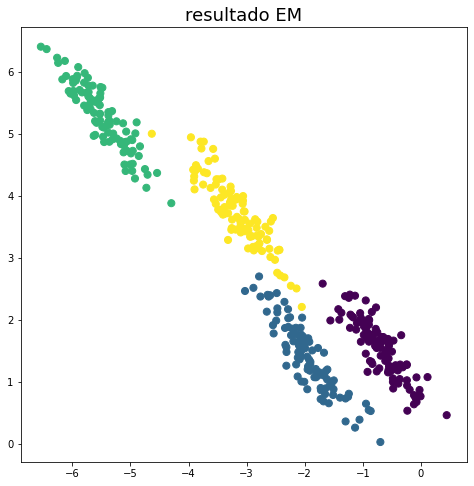

In [493]:
# Se muestran con el mismo color los puntos pertenecientes al mismo cluster.
fig, ax = plt.subplots()
ax.scatter(X_st[:, 0], X_st[:, 1], c=asignaciones_gmm, s=dot_size, cmap=cmap)
plt.title('resultado EM', fontsize=18)
plt.draw()